Este colab fue desarrollado por Arnold Charry Armero.

# XGBoost (Regresión)

XGBoost (Extreme Gradient Boosting) es una implementación avanzada del algoritmo de Gradient Boosting que combina la idea de entrenar modelos débiles de manera secuencial con mejoras en eficiencia y capacidad de generalización. Al igual que en el boosting clásico, cada nuevo árbol se ajusta para corregir los errores de los modelos anteriores mediante el uso de gradientes, siguiendo un esquema de descenso de gradiente funcional. La principal diferencia con respecto al Gradient Boosting tradicional es que XGBoost incorpora una expansión de segundo orden de la función objetivo (utilizando gradientes y hessianos), lo que permite optimizar de forma más precisa. Además, añade términos de regularización que penalizan la complejidad de los árboles, evitando el sobreajuste y favoreciendo modelos más simples y robustos. Gracias a estas innovaciones, XGBoost logra entrenamientos más rápidos, mejor rendimiento en grandes volúmenes de datos y mayor precisión, convirtiéndose en una de las técnicas más populares y efectivas en la práctica del aprendizaje automático. Matemáticamente se define la función objetivo de la siguiente manera incluyendo regularización,

$$
\mathcal{L}(\phi) = \sum_{i=1}^{n} l(y_i, \hat{y}_i) + \sum_{k=1}^{K} \Omega(f_k)
$$

donde:
- $l(y_i, \hat{y}_i)$: función de pérdida.
- $f_k$: árbol de decisión en la iteración $k$\.
- $\Omega(f_k)$: término de regularización que controla la complejidad del modelo.

En el caso de regresión, usando como pérdida el Error Cuadrático Medio (MSE):

$$ l(y_i, \hat{y}_i) = \frac{1}{2}(y_i - \hat{y}_i)^2 $$

La función objetivo se convierte en:

$$ \mathcal{L}(\phi) = \sum_{i=1}^{n} \frac{1}{2}(y_i - \hat{y}_i)^2 + \sum_{k=1}^{K} \Omega(f_k) $$

Ahora bien, la regularización en XGBoost es fundamental y se expresa como:

$$ \Omega(f) = \gamma T + \frac{1}{2}\lambda \sum_{j=1}^{T} w_j^2 $$

donde:
- $T$: número de hojas del árbol.
- $w_j$: peso asignado a la hoja $j$.
- $\gamma$: penalización por cada hoja adicional (controla profundidad).
- $\lambda$: penalización L2 sobre los pesos de las hojas.

Esto incentiva árboles más simples y evita el sobreajuste.

A diferencia del Gradient Boosting tradicional, XGBoost utiliza una aproximación de segundo orden de la función objetivo, lo que permite optimizar de manera más precisa:

$$
\mathcal{L}^{(t)} \simeq \sum_{i=1}^{n} \left[ g_i f_t(x_i) + \frac{1}{2} h_i f_t(x_i)^2 \right] + \Omega(f_t)
$$

donde:
- $ g_i = \frac{\partial l(y_i, \hat{y}_i^{(t-1)})}{\partial \hat{y}_i^{(t-1)}} $ (gradiente de primer orden).

- $ h_i = \frac{\partial^2 l(y_i, \hat{y}_i^{(t-1)})}{\partial (\hat{y}_i^{(t-1)})^2} $ (hessiano de segundo orden).
- $f_t(x)$: nuevo árbol añadido en la iteración $t$.

Cuando XGBoost construye un árbol, necesita decidir dónde dividir un nodo. Para ello, se calcula la ganancia de cada partición:

$$
\text{Gain} = \frac{1}{2} \left[ \frac{G_L^2}{H_L + \lambda} + \frac{G_R^2}{H_R + \lambda} - \frac{(G_L + G_R)^2}{H_L + H_R + \lambda} \right] - \gamma
$$

donde:
- $G_L, H_L$: suma de gradientes y hessianos de la izquierda.
- $G_R, H_R$: suma de gradientes y hessianos de la derecha.
- $\lambda, \gamma$: parámetros de regularización.

Si la ganancia es positiva, se realiza la división; si no, el nodo se convierte en una hoja.

XGBoost mejora al Gradient Boosting tradicional al:
1. Usar expansión de segundo orden (gradientes + hessianos).
2. Incorporar regularización explícita en la función objetivo.
3. Optimizar la construcción de árboles mediante la evaluación de la ganancia.

Ahora se continúa con la implementación en código,

In [ ]:
# Se importan las librerias
import math as mt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pandas.api.types import is_numeric_dtype, is_object_dtype, is_string_dtype
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Machine Learning/Bases de Datos/insurance.csv')

In [ ]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Primero se analiza la base de datos,

In [ ]:
# Se verifica la cantidad de datos
df.shape

(1338, 7)

Se puede observar que hay 1338 filas. Se observará de qué tipo son estos valores y si hay faltantes.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [ ]:
# Se verifica el tema de los faltantes
df.isnull().sum()[df.isnull().sum() != 0]

,0


Ahora se analizan las características con datos relevantes,

In [ ]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


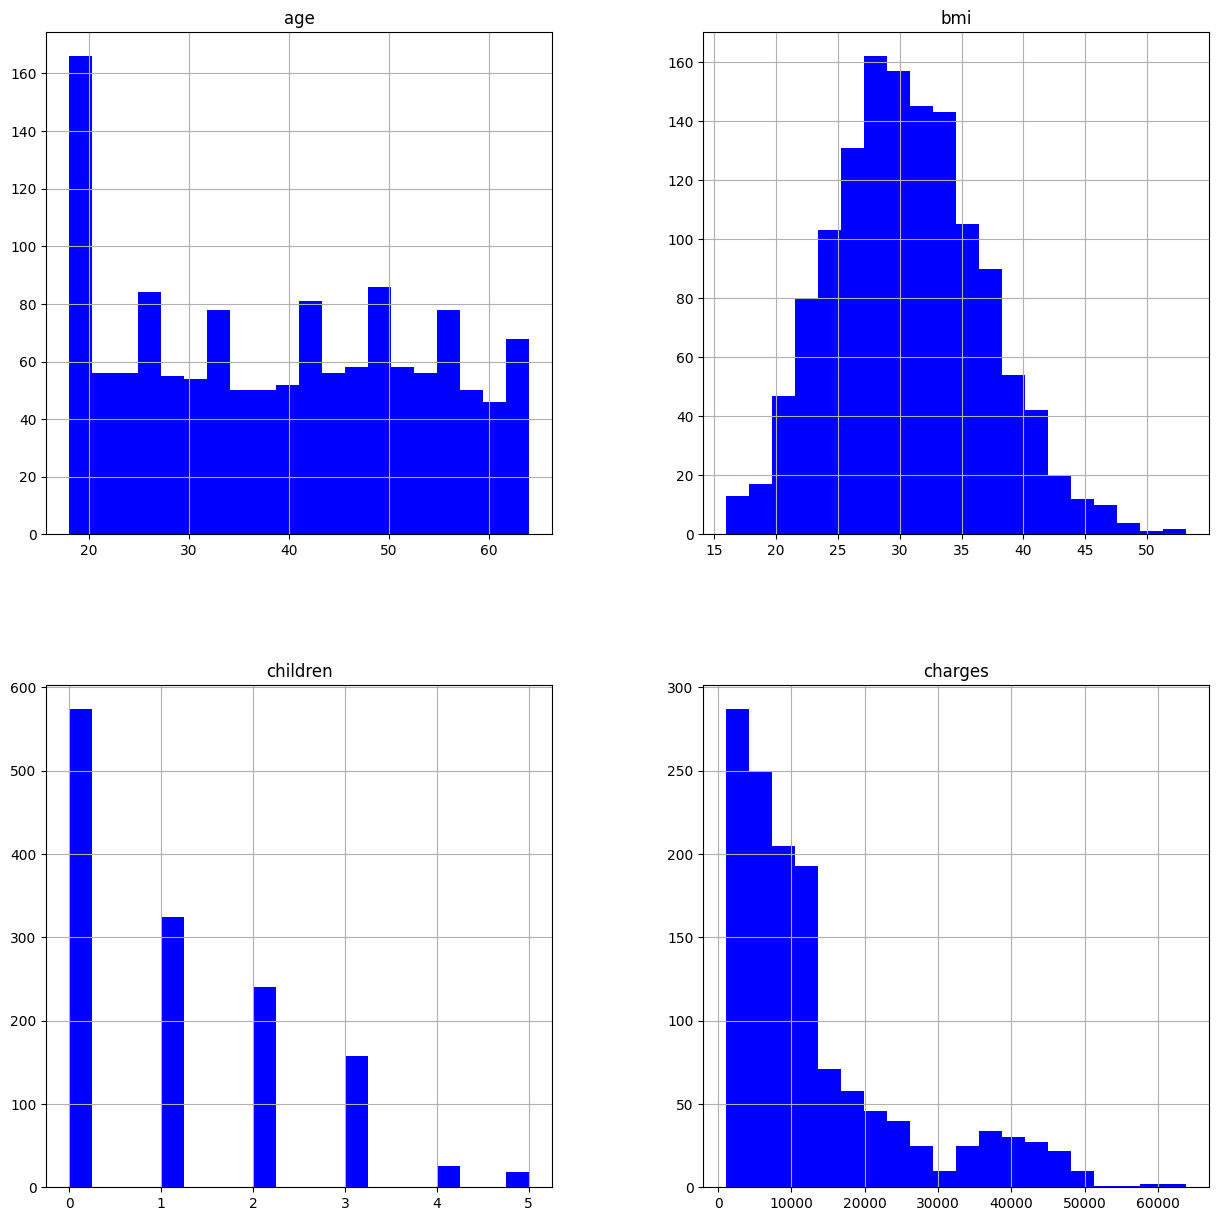

In [ ]:
df.hist(bins = 20, figsize = (15, 15), color = 'b')
plt.show()

## Preprocesamiento de Datos

In [ ]:
# Obtenemos las características
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [ ]:
# Se detectan las columnas categóricas
cat_cols = df.select_dtypes(include=['object', 'category']).columns
cat_indices = [df.columns.get_loc(col) for col in cat_cols]

# Se detectan las columnas numéricas
num_indices = [i for i in range(df.shape[1] - 1) if i not in cat_indices]

# Se crea el transformador
ct = ColumnTransformer(
    transformers=[('encoder', OneHotEncoder(drop='first',sparse_output=False, dtype=int), cat_indices)],
                    remainder='passthrough')

## Separación en Base de datos de Entrenamiento y Prueba

In [ ]:
# Se divide la base de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

## Escalado de Datos

In [ ]:
# Se escalan las variables y se hace one-hot encoder
X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

In [ ]:
# Visualizar el array X_train
print(X_train)

[[0 0 1 ... 46 19.95 2]
 [0 0 0 ... 47 24.32 0]
 [0 0 0 ... 52 24.86 0]
 ...
 [1 0 0 ... 58 25.175 0]
 [0 1 0 ... 37 47.6 2]
 [1 0 0 ... 55 29.9 0]]


## Entrenamiento del Modelo

Ahora vamos con el modelo XGBoost para regresión,

In [ ]:
XGB_model = XGBRegressor(n_estimators = 100, learning_rate = 0.1, random_state = 42)
XGB_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

Realizando una predicción,

In [ ]:
# Se debe de hacer en el orden original
print("Predicción:", XGB_model.predict(ct.transform([[19, 'female',	27.900, 0, 'no', 'northwest']]))[0])

Predicción: 2398.1326


In [ ]:
# Obtenemos las predicciones
y_pred = XGB_model.predict(X_test)
print(y_pred.reshape(len(y_pred),1))

[[ 1.01950586e+04]
 [ 7.18046826e+03]
 [ 2.98170156e+04]
 [ 8.67931738e+03]
 [ 3.45232617e+04]
 [ 6.48127637e+03]
 [ 1.27240161e+03]
 [ 1.59918115e+04]
 [ 4.44271045e+03]
 [ 9.90664648e+03]
 [ 1.92619004e+04]
 [ 7.75128760e+03]
 [ 4.49942578e+03]
 [ 4.51713086e+04]
 [ 4.80286523e+04]
 [ 4.38860859e+04]
 [ 9.42632324e+03]
 [ 4.26632852e+04]
 [ 9.00398145e+03]
 [ 2.36840527e+04]
 [ 6.52604248e+03]
 [ 8.71259668e+03]
 [ 1.20906152e+03]
 [ 2.80414038e+03]
 [ 1.10617422e+04]
 [ 1.25456543e+04]
 [ 1.54964648e+04]
 [ 6.72043799e+03]
 [ 1.11883916e+04]
 [ 6.40509766e+03]
 [ 6.70134668e+03]
 [ 1.17769600e+04]
 [ 3.56133618e+03]
 [ 4.89522070e+03]
 [ 3.15327661e+03]
 [ 9.21146387e+03]
 [ 3.27590405e+03]
 [ 8.02856885e+03]
 [ 2.36050352e+04]
 [ 3.91382656e+04]
 [ 4.89703369e+03]
 [ 5.41825879e+03]
 [ 1.32526104e+04]
 [ 1.90508594e+04]
 [ 7.39989111e+03]
 [ 1.38950498e+04]
 [ 1.75667520e+04]
 [ 7.52873193e+03]
 [ 4.32103164e+04]
 [ 8.10237549e+03]
 [ 1.47624570e+04]
 [ 3.31702368e+03]
 [ 6.6797143

## Rendimiento del Modelo

In [ ]:
# KPI's del Modelo
MAE = mean_absolute_error(y_test, y_pred)
print('MAE: {:0.2f}%'.format(MAE / np.mean(y_test) * 100))
MSE = mean_squared_error(y_test, y_pred)
RMSE = np.sqrt(MSE)
print('RMSE: {:0.2f}%'.format(RMSE / np.mean(y_test) * 100))
r2 = r2_score(y_test, y_pred)
print('R2: {:0.2f}'.format(r2))

MAE: 19.80%
RMSE: 35.44%
R2: 0.86


## Método del Codo para diferentes Árboles

Se hace un gráfico mirando cómo evoluciona el error a medida que se aumenta el número de árboles a entrenar,

In [ ]:
error_rates = []

for n in range(1, 101):
  model = XGBRegressor(n_estimators = n)
  model.fit(X_train, y_train)
  preds = model.predict(X_test)
  err = np.sqrt(mean_squared_error(y_test, preds)) / np.mean(y_test) * 100
  error_rates.append(err)

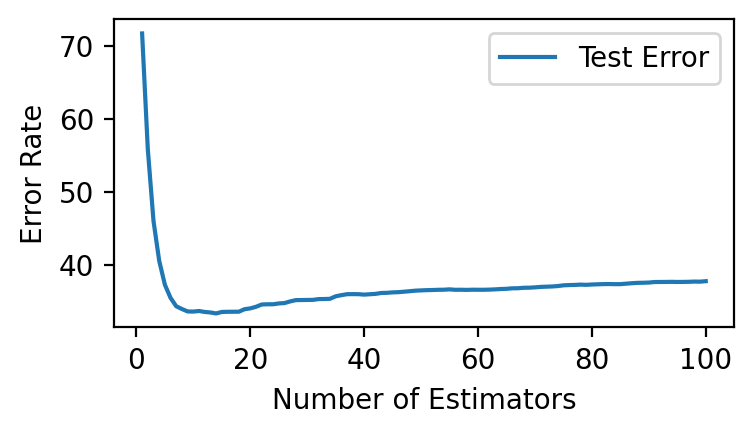

In [ ]:
plt.figure(figsize=(4, 2), dpi=200)
plt.plot(range(1, 101), error_rates, label='Test Error')
plt.legend()
plt.ylabel('Error Rate')
plt.xlabel("Number of Estimators")
plt.show()

## Validación Cruzada y Grid Search

Se mide el error cuadrático medio para la diferente selección de datos de entrenamiento y prueba,

In [ ]:
# Aplicar K-fold Cross Validation
scores = cross_val_score(estimator = XGB_model, X = X_train, y = y_train, cv = 10, scoring = 'neg_mean_squared_error')
print(np.sqrt(-scores.mean()))

5045.296040535329


Se conocen los parámetros de XGBoost para evaluar el GridSearch.


In [ ]:
XGB_model = XGBRegressor(random_state = 42)

In [ ]:
# Parámetros
XGB_model.get_params().keys()

dict_keys(['objective', 'base_score', 'booster', 'callbacks', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'device', 'early_stopping_rounds', 'enable_categorical', 'eval_metric', 'feature_types', 'feature_weights', 'gamma', 'grow_policy', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_bin', 'max_cat_threshold', 'max_cat_to_onehot', 'max_delta_step', 'max_depth', 'max_leaves', 'min_child_weight', 'missing', 'monotone_constraints', 'multi_strategy', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'random_state', 'reg_alpha', 'reg_lambda', 'sampling_method', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity'])

In [ ]:
# Se establecen los parámetros a probar
parameters = {
    "n_estimators": [25, 50, 100, 200],
    "learning_rate": [0.05, 0.1, 0.2],
    "max_depth": [3, 4, 5],
    "subsample": [0.8, 1],
    "colsample_bytree": [0.8, 1]}

In [ ]:
# Se utiliza GridSearchCV
full_cv_classifier = GridSearchCV(estimator = XGB_model,
                                  param_grid = parameters,
                                  cv = 10,
                                  scoring = 'neg_mean_squared_error',
                                  n_jobs = -1,
                                  verbose = 2)

In [ ]:
# Se entrena el CV_Classifier
full_cv_classifier.fit(X_train, y_train)

Fitting 10 folds for each of 144 candidates, totalling 1440 fits


GridSearchCV(cv=10,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=Non...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1],
                         'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [25, 50, 100, 200],
                         'subsample': [0.8, 1]},
             scoring='neg_mean_squared_error', verbose=2)

In [ ]:
print(full_cv_classifier.best_params_)

{'colsample_bytree': 1, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


In [ ]:
# Se obtiene el mejor resultado
print(np.sqrt(-full_cv_classifier.best_score_))

4578.39387230932


Ahora se vuelve a entrenar el modelo, pero con los parámetros óptimos.

In [ ]:
model = XGBRegressor(n_estimators = 100, learning_rate = 0.05, max_depth = 3, subsample = 0.8, colsample_bytree = 1, random_state = 42)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, ...)

In [ ]:
# Obtenemos las predicciones
y_pred = model.predict(X_test)
print(y_pred.reshape(len(y_pred),1))

[[10738.33  ]
 [ 6071.5576]
 [27291.578 ]
 [10395.503 ]
 [34566.434 ]
 [ 5766.521 ]
 [ 3147.3096]
 [14871.055 ]
 [ 4903.834 ]
 [11224.597 ]
 [18291.955 ]
 [ 8240.519 ]
 [ 5877.327 ]
 [45203.074 ]
 [47101.062 ]
 [45110.867 ]
 [11178.334 ]
 [44455.25  ]
 [ 9834.537 ]
 [23804.615 ]
 [ 6867.1216]
 [ 9002.075 ]
 [ 2158.2383]
 [ 3948.6904]
 [11933.108 ]
 [12724.253 ]
 [14756.957 ]
 [ 7023.6543]
 [11113.616 ]
 [ 2664.316 ]
 [ 8223.593 ]
 [12463.157 ]
 [ 3840.5066]
 [ 6670.2393]
 [ 4757.821 ]
 [ 9775.896 ]
 [ 3868.2776]
 [ 8870.806 ]
 [24427.346 ]
 [40563.55  ]
 [ 6136.7036]
 [ 4403.7065]
 [13664.479 ]
 [14181.074 ]
 [ 7544.5034]
 [15609.194 ]
 [ 6350.0767]
 [ 6225.4434]
 [42835.086 ]
 [ 7214.9297]
 [15077.307 ]
 [ 3651.7288]
 [ 7408.2705]
 [ 2554.2102]
 [12336.071 ]
 [11595.895 ]
 [ 5017.777 ]
 [40849.082 ]
 [12503.69  ]
 [12373.3125]
 [14497.562 ]
 [ 6698.5947]
 [17090.91  ]
 [ 8520.73  ]
 [11632.519 ]
 [ 6005.862 ]
 [18074.244 ]
 [12411.435 ]
 [ 5980.528 ]
 [ 2499.41  ]
 [ 7416.0596]
 [1070

In [ ]:
# Obteniendo la precisión del modelo
print('RMSE: {:0.2f}%'.format(np.sqrt(mean_squared_error(y_test, y_pred)) / np.mean(y_test) * 100))
print('MAE: {:0.2f}%'.format(mean_absolute_error(y_test, y_pred) / np.mean(y_test) * 100))
print('R2: {:0.2f}%'.format(r2_score(y_test, y_pred) * 100))

RMSE: 33.00%
MAE: 19.03%
R2: 88.20%


## Referencias

*   GeeksforGeeks. (2025, September 5). XGBoost. GeeksforGeeks. https://www.geeksforgeeks.org/machine-learning/xgboost/
*   Introduction to Boosted Trees — xgboost 3.0.5 documentation. (n.d.). https://xgboost.readthedocs.io/en/stable/tutorials/model.html
*   Medical cost personal datasets. (2018, February 21). Kaggle. https://www.kaggle.com/datasets/mirichoi0218/insurance
*   Leventis, D. (2022, January 2). XGBoost Mathematics Explained. Medium. https://dimleve.medium.com/xgboost-mathematics-explained-58262530904a
*   Vandeput, N. (2021). Data science for supply chain forecasting. de Gruyter.